# Motivation

In this notebook, we'll demonstrate how to train Detectron2 Mask-RCNN model to detect ships in aerial images. 

## Ship Aerial Dataset
We'll use [Airbus Ship Detection dataset](https://www.kaggle.com/c/airbus-ship-detection/).

As part of preparation, we alreaedy uploaded dataset to S3 bucket, preserving its orgiinal Kaggle structure.

## Requirements

### Installing Detectron2 on Notebook Instance

To run certain parts of this notebook such as local training and visualizations, you will need to have Detectron2 installed on notebook instance. If you are using Sagemaker P2 or P3 instance, use following instructions:
1. Open sepearate terminal window and run `source activate pytorch_latest_p36` command.
2. Install PyCOCOTools: `pip3.6 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'`
3. Install FVCore dependency: `pip3.6 install 'git+https://github.com/facebookresearch/fvcore'`
4. Installing dependency for Detectron2 visualization: `pip3.6 install google-colab`
5. Setting to use CUDA: `export FORCE_CUDA="1"`
6. Setting to build Detectron2 for specific CUDA architecture (Volta in our case): `export TORCH_CUDA_ARCH_LIST="Volta"`. If you use another CUDA architectures (e.g. "Turing"), you will need to update this parameter.
7. Finally, installing Detectron2 from latest sources: `pip3.6 install 'git+https://github.com/facebookresearch/detectron2.git'`

Note, after installation you may need to restart your kernel for changes to take effect.

In [2]:
import detectron2 # check that detectron2 was properly installed


### Updating Sagemaker Role

In order to build custom training and serving containers, you will need to attached additional Elastic Container Rregistry permissions to your Sagemaker Execution role. You can use of one AWS-authored policies (e.g. **"AmazonEC2ContainerRegistryPowerUser"**) or create your custom policy. Refer to [this article](https://docs.aws.amazon.com/sagemaker/latest/dg/security_iam_service-with-iam.html) for further details how Sagemaker works with permissions.

## Dataset preparations

In order to prepare Airbus dataset for Detectron2 consumption, you have to options:
- create custom Detectron2 dataloader which works with native dataset format;
- convert dataset to one of support dataset formats, such as [COCO2017 annotation format](https://cocodataset.org/#format-data).

For the purposes of this sample notebook, we'll use the second option. [This repository](https://github.com/pascal1129/kaggle_airbus_ship_detection/tree/master/0_rle_to_coco) provides an existing solution to do just that. Once we have a processed file with annotations, let's upload it back to our S3 location as we will use it at training time.

Once you have your dataset upload it to S3 bucket for further usage.

In [ ]:
#Let's copy prepared dataset from S3 bucket locally.
!aws s3 cp s3://d2-blog-east1/ ./

# Visualize Airbus dataset

Detectron2 provides number of facilities to work with dataset. In our cases, as our drone dataset is in COCO2017 format, we can leverage existing COCO2017 utility to register dataset: `register_coco_instances`

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data.catalog import MetadataCatalog, DatasetCatalog
import os

dataset_name = "airbus_train"
dataset_location = "./airbus_dataset"
annotation_file = "train.json"
image_dir = "training_set"

register_coco_instances(dataset_name, {}, os.path.join(dataset_location, annotation_file), 
                        os.path.join(dataset_location, image_dir))

ships_meta = MetadataCatalog.get(dataset_name)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
# Print meta info about our dataset
ships_meta

Metadata(evaluator_type='coco', image_root='./airbus_dataset/training_set', json_file='./airbus_dataset/train.json', name='airbus_train')

If you are interested to see the input of our model, feel free to execute cell below. Here, dataset_dicts provides a mapping between images and groundtruth values (bounding boxes and segmentation masks)

In [5]:
dataset_dicts = DatasetCatalog.get(dataset_name)

# Let's review first training image with annotations
print(dataset_dicts[0])

{'file_name': './airbus_dataset/training_set/23cbe4a44.jpg', 'height': 768, 'width': 768, 'image_id': 1, 'annotations': [{'iscrowd': 0, 'bbox': [518.0, 311.0, 53.0, 54.0], 'category_id': 0, 'segmentation': [[527.0, 364.5, 517.5, 355.0, 560.0, 310.5, 570.5, 321.0, 527.0, 364.5]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


Now, let's visualize our input images and groundtruth bounding boxes and segementation masks.

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


./airbus_dataset/training_set/452266b78.jpg


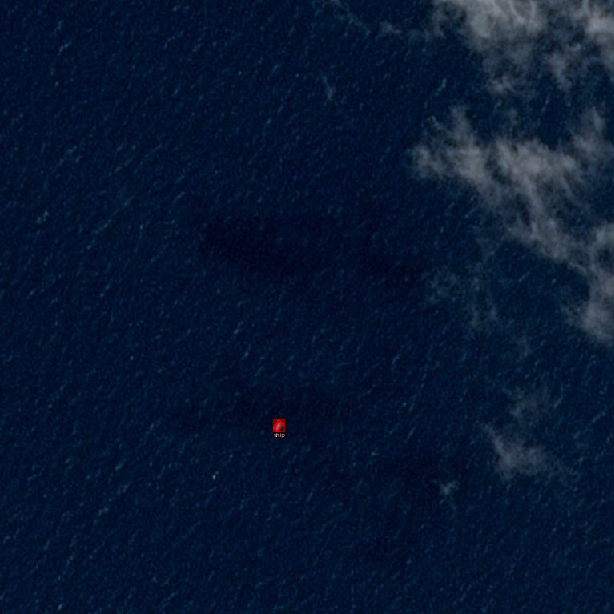

./airbus_dataset/training_set/ff1f49bda.jpg


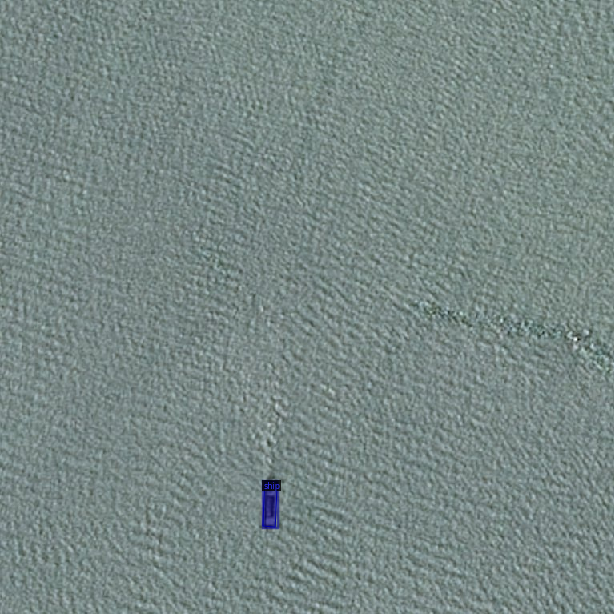

./airbus_dataset/training_set/ca8fbfbfa.jpg


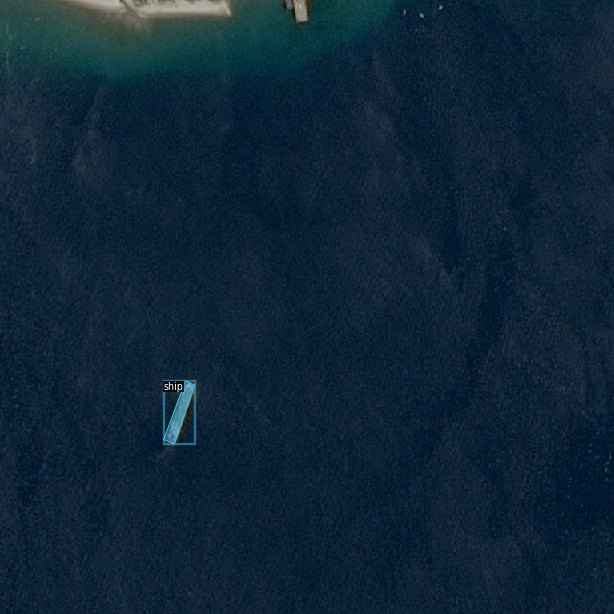

./airbus_dataset/training_set/65a4b74d2.jpg


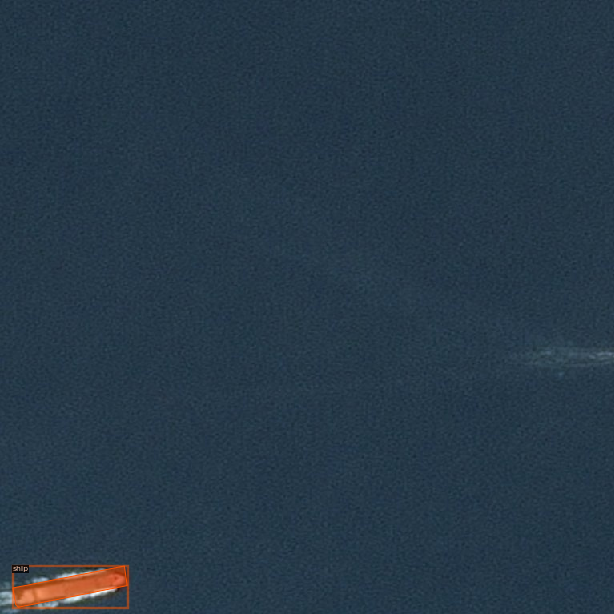

./airbus_dataset/training_set/f16a69c37.jpg


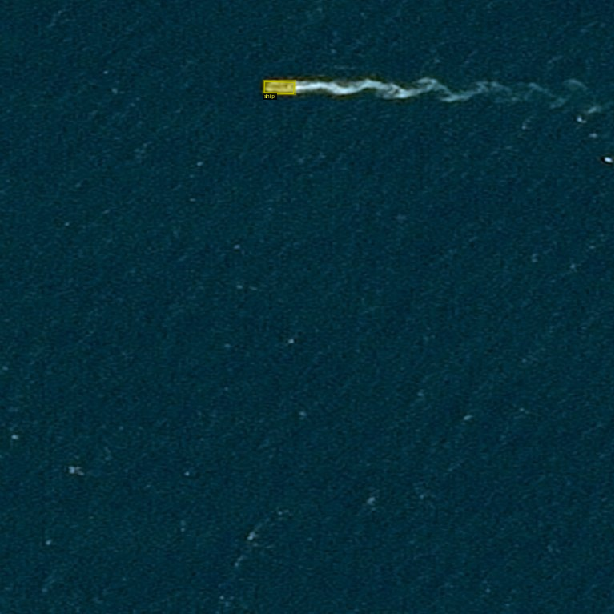

In [6]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow
 
for d in random.sample(dataset_dicts, 5):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=ships_meta, scale=0.8)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Experiment with Detectron2 locally


Let's first check if we can fine tune model locally. Training your model locally may be a good choice in case of small models and small datasets. In our cases, let's test that model can perform finetuning on custom dataset for limited number of iterations. 

If this is successfull, we'll then go ahead and train model for larger number of iterations across multiple nodes.

In [ ]:
# Do initial configuration
from detectron2.config import get_cfg
from detectron2 import model_zoo

config_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = (5000)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    32
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.OUTPUT_DIR = "sem_seg_output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine import DefaultTrainer

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Now, let's generate predictions locally, using one of images from dataset.

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (dataset_name, )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("./airbus_dataset/ships_train2018/3c4105048.jpg")
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
               metadata=ships_meta, 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## Fine tune Detectron2 model using Sagemaker distributed training

So, we confirmed that our model can train on our customer dataset. Now let's run distributed training for larger number of iteraships_meta across multiple nodes/GPU device in Sagemaker Training cluster. 

This will include following steps:
1. Create training script capable of running/coordinating training tasks in distributed environment;
2. Prepare customer Docker container with configured training runtime and training scripts;
3. Build and push training container in Elastic Container Registry
4. Schedule training job via Sagemaker Python SDK


### Step 1. Prepare training script for distributed cluster.
Find below listing of training script which can run either on single node or multiple nodes with multiple GPU devices. Several highlights:
1. **Line #186** - Sagemaker will start training by running code in `__main__` guard on all training nodes;
2. **Line #143** - in order to coordinate communication between different nodes, we need to gather details about our training world such as number of nodes, number of devices etc.
3. **Line #207** - we use Detectron2 launch utility to start training on multiple nodes.
4. **Line #169** - actual training script which will be executed on all processes and all GPU devices. Under the hood, PyTorch [DistributedDataParallel](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) class will ensure coordination of tasks between GPU devices. 


In [ ]:
! pygmentize container_training/train_airbus.py  | cat -n

### Step 2. Prepare training container

We will build a custom container with specific Detectron2 training runtime envrionment. As a vase image, we'll use latest Sagemaker PyTorch Container, and then further extend it with Detectron2 requirements.

Before we beging we need to make sure that we have access to Sagemaker ECR (to pull base image) and our account ECR (to push custom container). Execute code below to loging to both ECRs. **Note** that you will need to provide below your AWS account number.

In [ ]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-1.amazonaws.com

Now, let's review our Dockerfile for training. It includes following instructions:
1. Define base container;
2. Install required dependencies for Detectron2;
3. Copies training script and utilities to container;
4. Builds Detectron2 from source.

In [ ]:
!pygmentize -l docker Dockerfile.airbustraining

### Step 3. Build and push custom training container

We provide a simple bash script to build locally training container and push it to your account ECR. If needed, you can specific different image name, tag, or Dockerfile. 

In [ ]:
! ./build_and_push.sh d2-sm-airbus latest Dockerfile.airbustraining 

### Step 4. Schedule Sagemaker Training Job

Once we have training container in our ECR, we are ready to schedule our distributed training job. 

First, we'll need to do several common imports and configurations. Feel free to customize it as needed.

In [61]:
# Define IAM role
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

In [62]:
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket()
region = "us-east-1"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
prefix_input = 'detectron2-input'
prefix_output = 'detectron2-ouput'

In [63]:
# your container name and tag should match ones you used at Step 3.

container = "d2-sm-airbus" 
tag = "latest"
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container, tag)

In [ ]:
from sagemaker.inputs import FileSystemInput

training = FileSystemInput(
    file_system_id="fs-0225448c20fa073d0",
#     file_system_id="d2-demo",
    file_system_type="FSxLustre",
#     directory_path="/t7wl5bmv/fsx/airbus_dataset",
    directory_path="/fsx/airbus-dataset",    
    file_system_access_mode='ro'
)

In [ ]:
role

In [ ]:
# Metric definitions will be extracted by Sagemaker from your training script output and displayed in training job console in real-time.

metric_definitions=[
    {
        "Name": "total_loss",
        "Regex": ".*total_loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_cls",
        "Regex": ".*loss_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_box_reg",
        "Regex": ".*loss_box_reg:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_mask",
        "Regex": ".*loss_mask:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_cls",
        "Regex": ".*loss_rpn_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_loc",
        "Regex": ".*loss_rpn_loc:\s([0-9\\.]+)\s*"
    }, 
    {
        "Name": "overall_training_speed",
        "Regex": ".*Overall training speed:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "lr",  
        "Regex": ".*lr:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "iter",  
        "Regex": ".*iter:\s([0-9\\.]+)\s*"
    }
]


In [ ]:
hyperparameters = {"config-file":"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", 
                   #"local-config-file" : "config.yaml", # if you'd like to supply custom config file, please add it in container_training folder,
                                                         # and provide file name here
                   "resume":"True", # whether to re-use weights from pre-trained model
                  # opts are D2 model configuration as defined here: https://detectron2.readthedocs.io/modules/config.html#config-references
                  # this is a way to override individual parameters in D2 configuration from Sagemaker API
                   "opts": "SOLVER.MAX_ITER 1000 \
                   MODEL.ROI_HEADS.NUM_CLASSES 1\
                   SOLVER.REFERENCE_WORLD_SIZE 8"
                   }
    
d2 = sagemaker.estimator.Estimator(image_uri=image,
                                   role=role,
                                   train_instance_count=1, 
                                   train_instance_type='ml.p3.16xlarge',
                                   train_volume_size=100,
                                   output_path="s3://{}/{}".format(sess.default_bucket(), prefix_output),
                                   metric_definitions = metric_definitions,
                                   hyperparameters = hyperparameters, 
                                   sagemaker_session=sagemaker.Session(),                                 
                                   subnets=["subnet-027f5ac929fb1fceb"],
                                   security_group_ids=["sg-02073864cd2421c16"]
                                  )

d2.fit(inputs={'training': training}, job_name="airbus-train-21", logs="All", wait=True) 

In [ ]:
# download from S3

hyperparameters = {"config-file":"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", 
                   #"local-config-file" : "config.yaml", # if you'd like to supply custom config file, please add it in container_training folder,
                                                         # and provide file name here
                   "resume":"True", # whether to re-use weights from pre-trained model
                  # opts are D2 model configuration as defined here: https://detectron2.readthedocs.io/modules/config.html#config-references
                  # this is a way to override individual parameters in D2 configuration from Sagemaker API
                   "opts": "SOLVER.MAX_ITER 10000 \
                   MODEL.ROI_HEADS.NUM_CLASSES 1\
                   SOLVER.REFERENCE_WORLD_SIZE 8"
                   }
    
d2 = sagemaker.estimator.Estimator(image_uri=image,
                                   role=role,
                                   train_instance_count=1, 
                                   train_instance_type='ml.p3.16xlarge',
                                   train_volume_size=100,
                                   output_path="s3://{}/{}".format(sess.default_bucket(), prefix_output),
                                   metric_definitions = metric_definitions,
                                   hyperparameters = hyperparameters, 
                                   sagemaker_session=sagemaker.Session(),                                 
#                                    subnets=["subnet-027f5ac929fb1fceb"],
#                                    security_group_ids=["sg-02073864cd2421c16"]
                                  )

d2.fit(inputs={'training': "s3://d2-blog-east1/airbus-dataset/"}, job_name="airbus-train-22", logs="All", wait=True) 



In [ ]:
# Let's get model data from training job which we'll use later during model deployment
model_url = d2.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts']

## Deploying trained model to remote endpoint

To deploy model remotely, we'll need to do following:
1. Prepare, build, and push custom serving containers;
2. Deploy container for serving via Sagemaker SDK.

### Step 1. Build and push custom serving container

Let's review prepared custom container. Note following differences from training container:
1. We are using Sagemaker inference container as a base image. It comes with pre-installed model serving, so no additional configuration or installation is required.
2. We build Detectron2 for `Turing` architecture as we plan to use price-performance optimal G4 instance type for serving. G4 instance has NVidia Turing chips.

In [ ]:
!pygmentize -l docker Dockerfile.serving

Next, we'll build and push this container to account ECR. 

In [ ]:
! ./build_and_push.sh d2-airbus-serving latest Dockerfile.airbusserving

In [64]:
container_serving = "d2-airbus-serving" # your container name
tag = "latest" # you can have several version of container available
image = f"{account}.dkr.ecr.{region}.amazonaws.com/{container_serving}:{tag}"
    
print(f"Following serving container will be used: {image}")

Following serving container will be used: 553020858742.dkr.ecr.us-east-1.amazonaws.com/d2-airbus-serving:latest


### Step 2. Deploy Sagemaker endpoint 

We'll use Sagemaker Python SDK to deploy endpoint.

In [ ]:
from sagemaker.pytorch import PyTorchModel

remote_model = PyTorchModel(
                     name = "d2-airbus-model-3", 
                     model_data="s3://sagemaker-us-east-1-553020858742/detectron2-ouput/airbus-train-22/output/model.tar.gz",
                     role=role,
                     sagemaker_session = sess,
                     entry_point="predict_airbus.py", source_dir="container_serving",
                     image_uri=image, 
                     framework_version="1.5.1",
                    )

In [8]:
endpoint_name = "airbus-serving-3"

# remote_predictor = remote_model.deploy(
#                          instance_type='ml.g4dn.xlarge', 
#                          initial_instance_count=1,
# #                         update_endpoint = True, # comment or False if endpoint doesns't exist
#                          endpoint_name=endpoint_name, # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
# #                          tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
# #                         wait=False # Uncomment if you don't want to see deployment progress in notebook
#                          )

## Testing on unseen pictures

Let's get a few unseen by model pictures to test our deployed model.

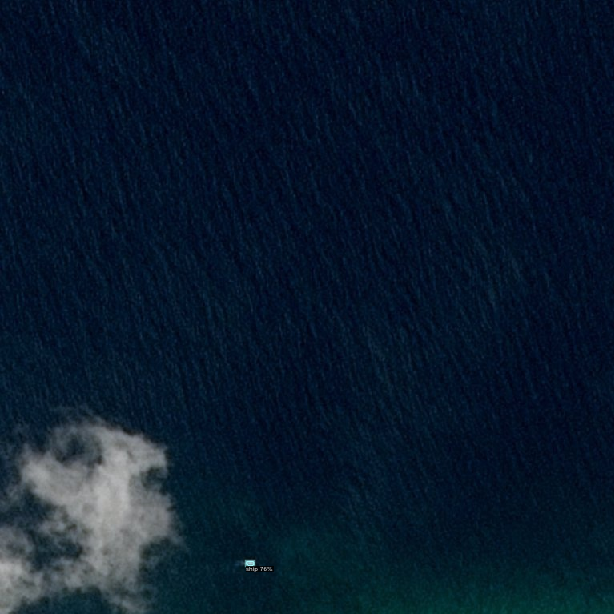

Counted 1 ships on the photo. 
 
 



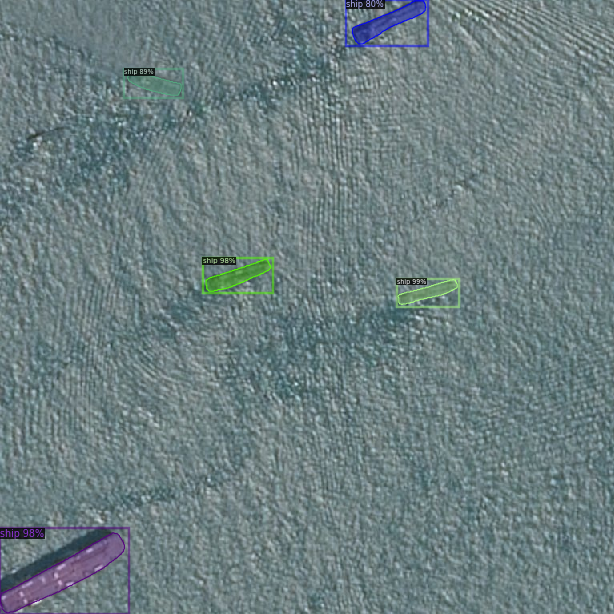

Counted 5 ships on the photo. 
 
 



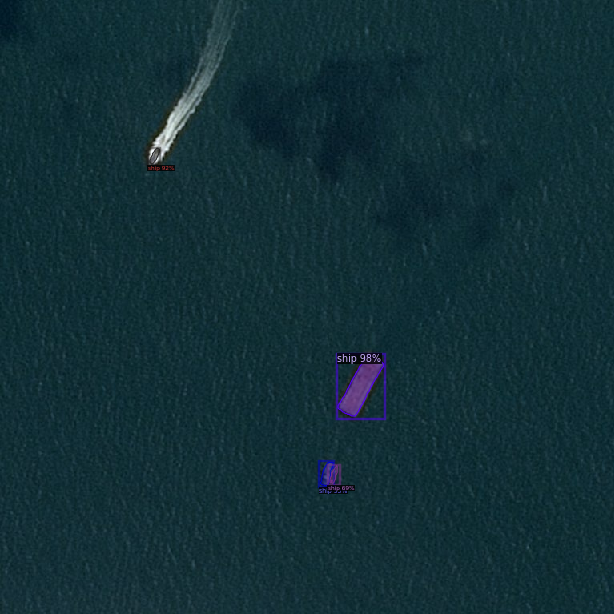

Counted 4 ships on the photo. 
 
 



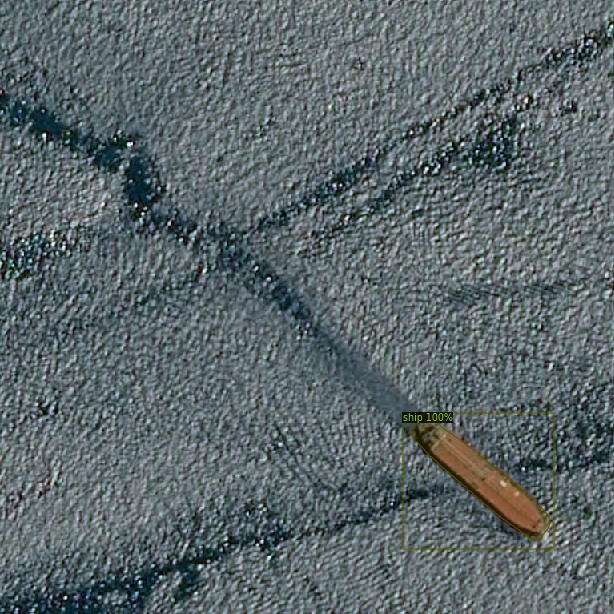

Counted 1 ships on the photo. 
 
 



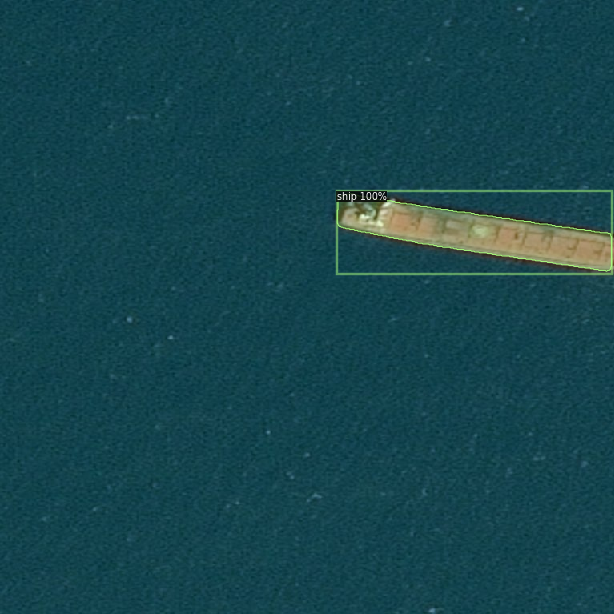

Counted 1 ships on the photo. 
 
 



In [88]:
import boto3
from io import BytesIO
from container_serving import d2_deserializer
from container_serving import utils
from google.colab.patches import cv2_imshow

import importlib
importlib.reload(utils)
importlib.reload(d2_deserializer)

client = boto3.client('sagemaker-runtime')
accept_type = "json" # "json" or "detectron2". Won't impact predictions, just different deserialization pipelines.
content_type = 'image/jpeg'
headers = {'content-type': content_type}
device = "cuda:0"

for d in random.sample(dataset_dicts, 5):
    payload = open(d["file_name"], 'rb')
    response = client.invoke_endpoint( 
        EndpointName=endpoint_name,
        Body=payload,
        ContentType=content_type,
        Accept = accept_type
    )
    decoded = response['Body'].read().decode('utf-8')
    predictions, counter = d2_deserializer.json_to_d2(decoded, device)
    if predictions is not None:
        cv2_imshow(utils.d2_visualizer(d["file_name"], predictions, dataset_name))
    else:
        cv2_imshow(cv2.imread(d["file_name"]))

    print(f"Counted {counter} ships on the photo. \n \n \n")